In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import numpy as np

import matplotlib as mpl

import IPython.display as display
import PIL.Image

from tensorflow.keras.preprocessing import image

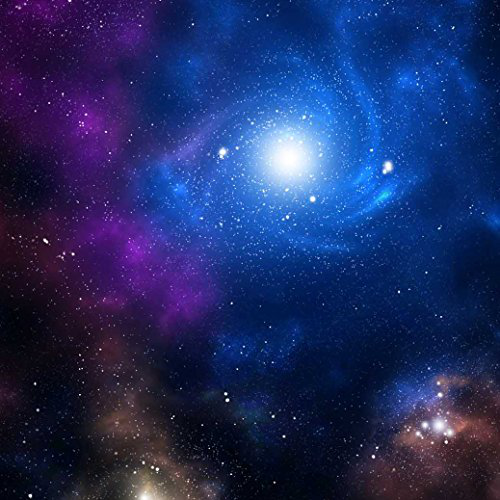

In [2]:
def download(url, max_dim=None):
    name = url.split('/')[-1]
    image_path = tf.keras.utils.get_file(name, origin=url)
    img = PIL.Image.open(image_path)
    if max_dim:
        img.thumbnail((max_dim, max_dim))
    return np.array(img)

def img_loader(path, max_dim=None):
    img = PIL.Image.open(path)
    if max_dim:
        img.thumbnail((max_dim), (max_dim))
    return np.array(img)

def deprocess(img):
  img = 255*(img + 1.0)/2.0
  return tf.cast(img, tf.uint8)

def show(img):
  display.display(PIL.Image.fromarray(np.array(img)))

#original_img = download(url, max_dim=500)
path = "D:/DRIVERS/space_low_res2.jpg"
original_img = img_loader(path, max_dim=None)
show(original_img)

In [3]:
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

the inceptionv3 contains different layers from 0 to 10 i.e 11 layers 
the higher the layer it has more complex stuff to find and take much more time to compute

In [4]:
names = ['mixed3','mixed5','mixed6']
layers = [base_model.get_layer(name).output for name in names]

dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)

In [5]:
def calc_loss(img, model):
    img_batch = tf.expand_dims(img, axis=0)
    layer_activations = model(img_batch)
    
    losses = []
    for act in layer_activations:
        loss = tf.math.reduce_mean(layer_activations)
        losses.append(loss)
    return tf.reduce_sum(losses)
# try playing with the for loop for activations in layer_activations\
# also try removing it

# find why to use @tf.function


In [6]:
class DeepDream(tf.Module):
    def __init__(self, model):
        self.model = model
        
    @tf.function(
        input_signature=(
            tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
            tf.TensorSpec(shape=[], dtype=tf.int32),
            #tf.TensorSpec(shape=[], dtype=tf.int32),
            tf.TensorSpec(shape=[], dtype=tf.float32),)
    )
    def __call__(self, img, steps, step_size):
      print("Tracing")
      loss = tf.constant(0.0)
      for n in tf.range(steps):
        with tf.GradientTape() as tape:
          tape.watch(img)
          loss = calc_loss(img, self.model)
        gradients = tape.gradient(loss, img)
        #normalize gradients
        gradients /= tf.math.reduce_std(gradients) + 1e-8 
        
        img = img + gradients*step_size
        img = tf.clip_by_value(img, -1, 1)

      return loss, img

# tf.GradientTape()
# tape.gradient()

In [7]:
deepdream = DeepDream(dream_model)

In [8]:
def run_dd_simple(img, steps, step_size):
    #Converting from uint8 to the range expected by the model.
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    img = tf.convert_to_tensor(img)
    step_size = tf.convert_to_tensor(step_size)
    steps_remaining = steps
    step = 0
    while steps_remaining:
        if steps_remaining>100:
            run_steps = tf.constant(100)
        else:
            run_steps = tf.constant(steps_remaining)
        steps_remaining -=run_steps
        step += run_steps
        
        loss, img = deepdream(img, run_steps, tf.constant(step_size))
        
        display.clear_output(wait=True)
        show(deprocess(img))
        print("Step {}, loss {}".format(step, loss))
        
    result = deprocess(img)
    display.clear_output(wait=True)
    show(result)
    
    return result

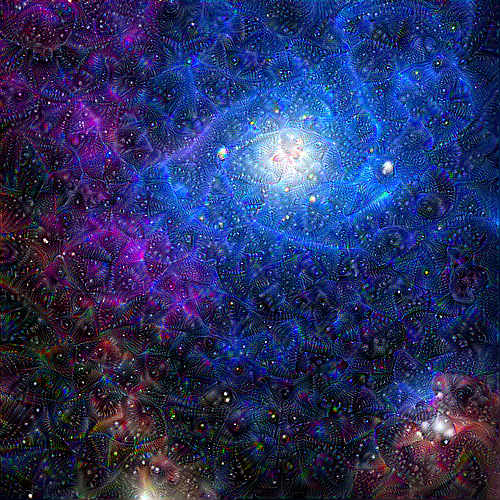

In [9]:
dream_img = run_dd_simple(img=original_img, steps=200, step_size=0.01)

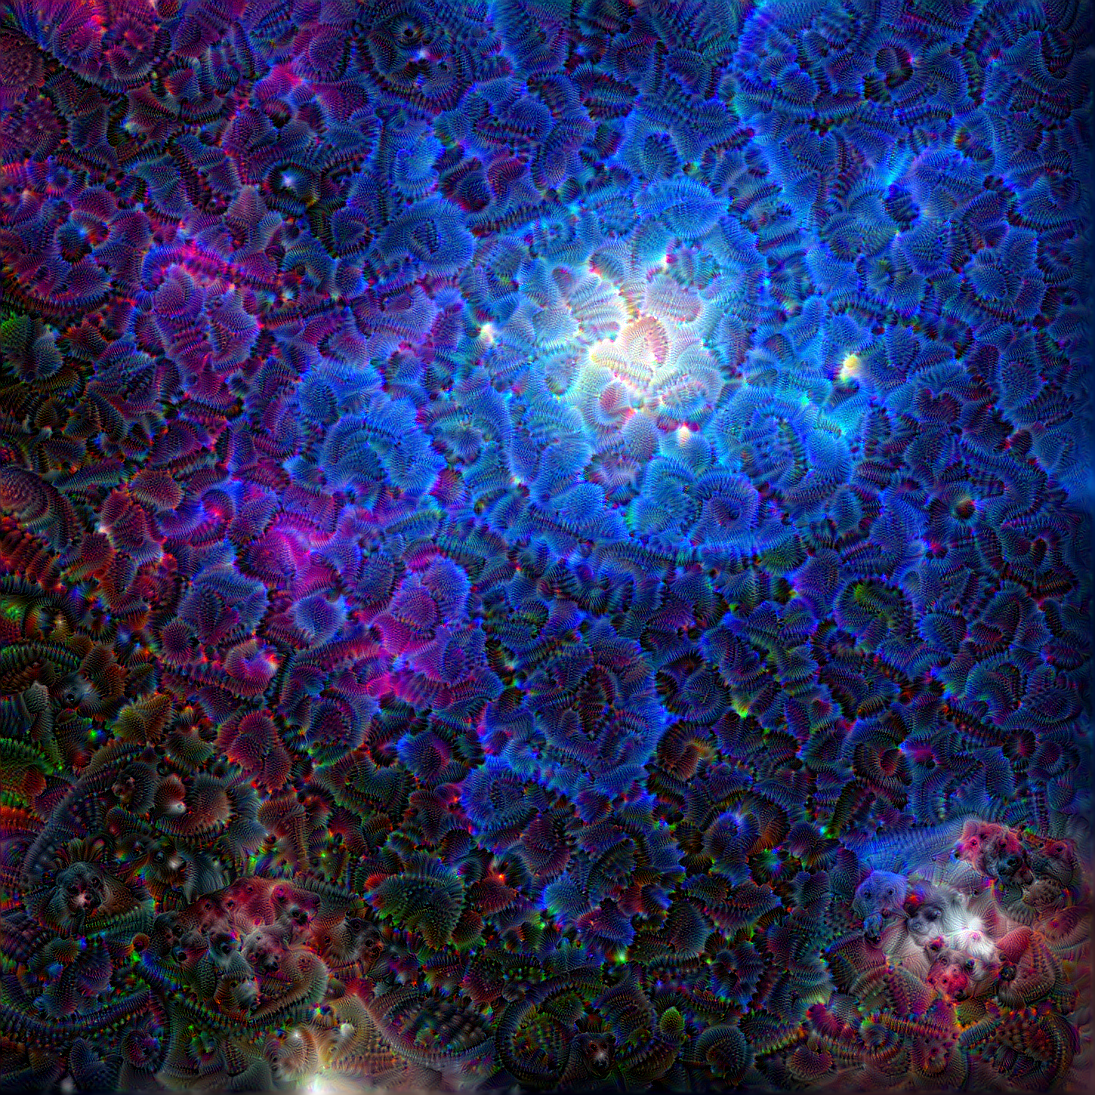

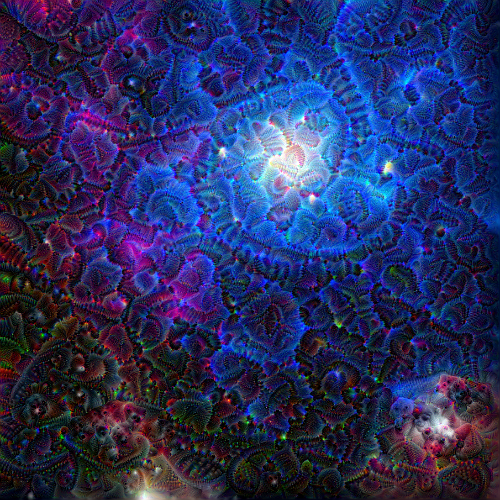

In [41]:
import time
start = time.time()

img_scale = 1.48

img = tf.constant(np.array(original_img))
base_img = tf.shape(img)[:-1]
float_base = tf.cast(base_img, tf.float32)

for n in range(-3, 3):
  new_shape = tf.cast(float_base*(img_scale**n), tf.int32)
  print(new_shape)
  img = tf.image.resize(img, new_shape).numpy()

  img = run_dd_simple(img=img, steps=50, step_size=0.01)
    
display.clear_output(wait=True)
img = tf.image.resize(img, base_img)
img = tf.image.convert_image_dtype(img/255.0, dtype=tf.uint8)
show(img)

end = time.time()